# 01. Exploratory Data Analysis
## Quantitative Trading Strategy Development

### Objectives:
1. Load and understand the data structure
2. Analyze statistical properties of returns and signals
3. Identify patterns, anomalies, and relationships
4. Visualize key insights
5. Form hypotheses for model development

In [57]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import adfuller, acf, pacf
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.6f' % x)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading and Initial Inspection

In [58]:
# Load data
def load_data(filepath='../data/raw/synthetic_data.csv', Tcost=0.005):
    """Load and clean the data from CSV file."""
    # Read CSV file
    df_raw = pd.read_csv(filepath)
    
    # Extract transaction cost
    transaction_cost = Tcost
    print(f"Transaction cost: {transaction_cost:.3f} ({transaction_cost*100:.1f}%)")
    
    # Find header row
    # Robustly locate header row (look for a cell that equals 'Date' ignoring case/whitespace or contains 'date')
    if df_raw.columns.astype(str).str.strip().str.lower().str.contains('date').any():
        header = df_raw.columns.astype(str).str.strip()
        df = df_raw.copy().reset_index(drop=True)
        print("Header inferred from CSV column names.")
        

    # Normalize column names and assign
    header = header.astype(str).str.strip().str.replace(r'\s+', '_', regex=True)
    df.columns = header
    # Standardize column name casing to be robust but keep capital 'Date' for downstream cells
    df.columns = [col if col.lower() != 'date' else 'Date' for col in df.columns]

    # Drop entirely empty columns
    df = df.dropna(axis=1, how='all')

    # Parse Date column
    df['Date'] = pd.to_numeric(df['Date'], errors='coerce')
    
    # Convert other columns to numeric where appropriate
    for col in df.columns:
        if col == 'Date':
            continue
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df, transaction_cost

# Load the data
df, transaction_cost = load_data()
print(f"\nData shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Transaction cost: 0.005 (0.5%)
Header inferred from CSV column names.

Data shape: (1500, 12)
Date range: 1 to 1500

Columns: ['Date', 'Returns', 'momentum_factor', 'value_factor', 'volatility_factor', 'quality_factor', 'size_factor', 'liquidity_factor', 'sentiment_factor', 'technical_factor', 'macro_factor', 'carry_factor']

First few rows:


,Date,Returns,momentum_factor,value_factor,volatility_factor,quality_factor,size_factor,liquidity_factor,sentiment_factor,technical_factor,macro_factor,carry_factor
0,1,-0.001184,2.171951,3.983742,1.321201,-0.894391,1.194561,0.203151,0.643373,1.025044,0.636287,-1.048456
1,2,0.005756,-2.525728,3.516477,1.123330,-0.878629,-0.626496,1.698226,1.062987,0.512342,0.392438,-0.754294
2,3,0.006604,-1.455066,2.542317,0.797953,-0.885487,-0.670347,-0.137689,1.127295,0.393055,0.775144,-0.896938
3,4,0.002620,-0.245745,2.427460,0.826050,-1.331101,-0.299799,-0.448112,0.853782,0.348977,0.518074,-1.135397
4,5,0.008938,-4.025246,1.841812,0.911840,-1.144210,-0.349545,-0.355411,0.391753,0.132935,0.300755,-0.812469


In [59]:
# Data quality checks
print("Data Quality Report")
print("="*50)
print(f"Total observations: {len(df)}")
print(f"Missing values per column:")
print(df.isnull().sum())
print(f"\nData types:")
print(df.dtypes)
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024:.2f} KB")

Data Quality Report
Total observations: 1500
Missing values per column:
Date                 0
Returns              0
momentum_factor      0
value_factor         0
volatility_factor    0
quality_factor       0
size_factor          0
liquidity_factor     0
sentiment_factor     0
technical_factor     0
macro_factor         0
carry_factor         0
dtype: int64

Data types:
Date                   int64
Returns              float64
momentum_factor      float64
value_factor         float64
volatility_factor    float64
quality_factor       float64
size_factor          float64
liquidity_factor     float64
sentiment_factor     float64
technical_factor     float64
macro_factor         float64
carry_factor         float64
dtype: object

Memory usage: 140.75 KB


## 2. Statistical Analysis of Asset Returns

In [60]:
# Analyze return distribution
returns = df['Returns'].values

# Calculate statistics
return_stats = {
    'Mean': np.mean(returns),
    'Median': np.median(returns),
    'Std Dev': np.std(returns),
    'Skewness': stats.skew(returns),
    'Kurtosis': stats.kurtosis(returns, fisher=False),
    'Min': np.min(returns),
    'Max': np.max(returns),
    '5% Percentile': np.percentile(returns, 5),
    '95% Percentile': np.percentile(returns, 95),
    'Annualized Return': np.mean(returns) * 252,
    'Annualized Volatility': np.std(returns) * np.sqrt(252),
    'Sharpe Ratio': (np.mean(returns) * 252) / (np.std(returns) * np.sqrt(252))
}

print("Asset Returns Statistics")
print("="*40)
for key, value in return_stats.items():
    print(f"{key:20s}: {value:12.6f}")

# Normality test
jb_stat, jb_pvalue, _, _ = jarque_bera(returns)
print(f"\nJarque-Bera test: statistic={jb_stat:.4f}, p-value={jb_pvalue:.4f}")
if jb_pvalue < 0.05:
    print("Returns are NOT normally distributed (reject null hypothesis)")
else:
    print("Returns appear to be normally distributed")

Asset Returns Statistics
Mean                :    -0.000160
Median              :    -0.000006
Std Dev             :     0.005923
Skewness            :     0.028240
Kurtosis            :     3.097438
Min                 :    -0.019130
Max                 :     0.022877
5% Percentile       :    -0.010065
95% Percentile      :     0.009271
Annualized Return   :    -0.040380
Annualized Volatility:     0.094029
Sharpe Ratio        :    -0.429442

Jarque-Bera test: statistic=0.7928, p-value=0.6728
Returns appear to be normally distributed


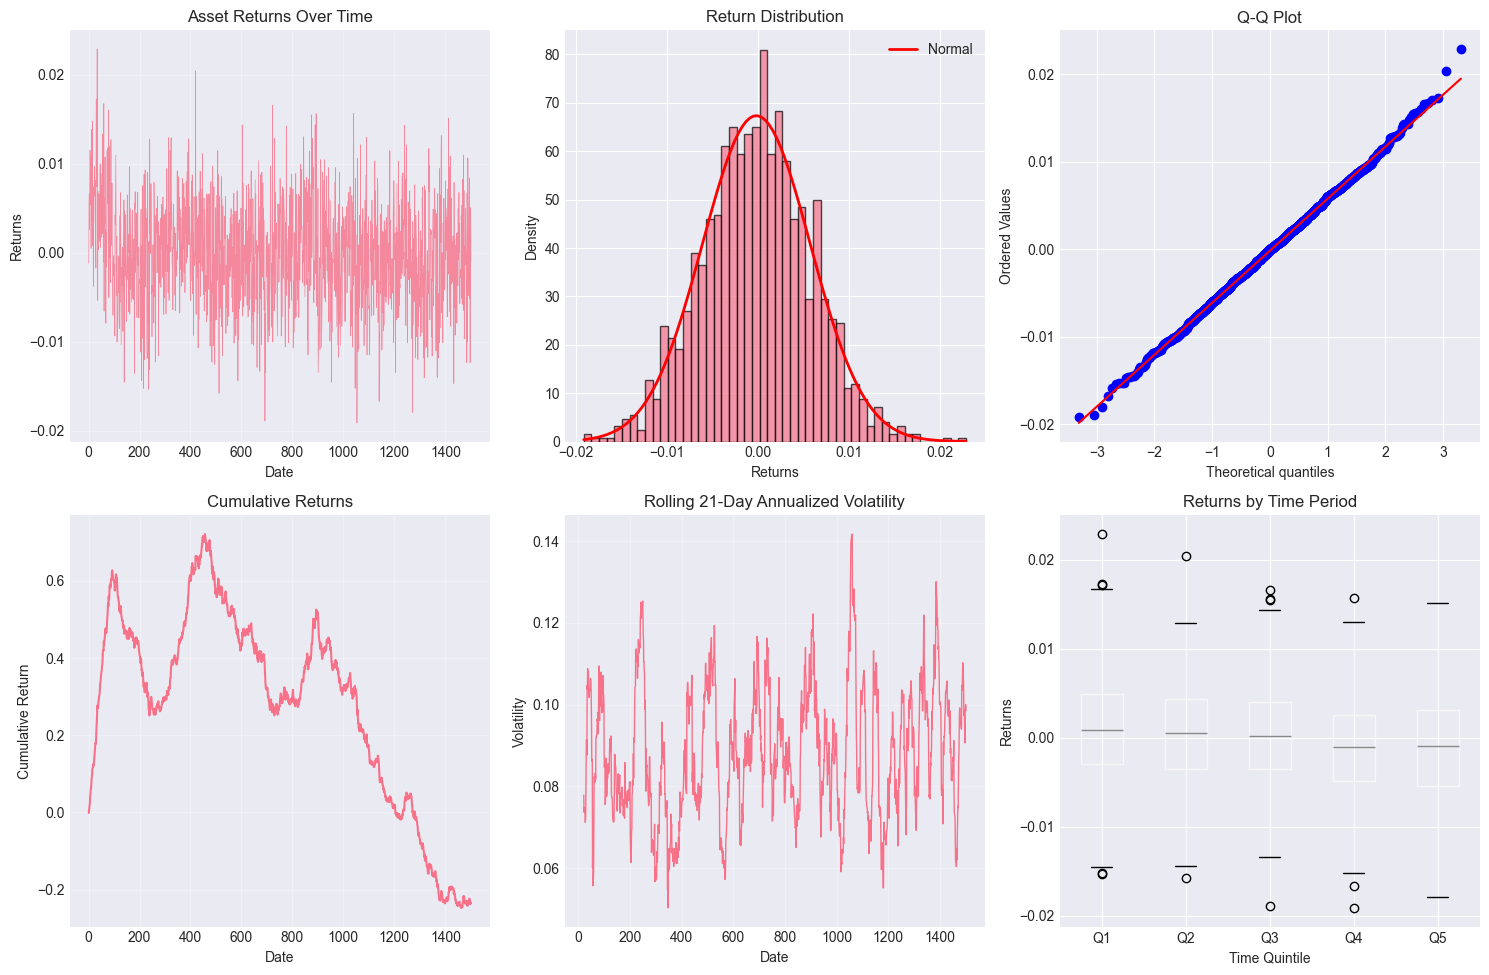

In [61]:
# Visualize return distribution
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Time series plot
axes[0, 0].plot(df['Date'], returns, linewidth=0.5, alpha=0.8)
axes[0, 0].set_title('Asset Returns Over Time')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Returns')
axes[0, 0].grid(True, alpha=0.3)

# Histogram with normal overlay
axes[0, 1].hist(returns, bins=50, density=True, alpha=0.7, edgecolor='black')
x = np.linspace(returns.min(), returns.max(), 100)
axes[0, 1].plot(x, stats.norm.pdf(x, np.mean(returns), np.std(returns)), 
                'r-', linewidth=2, label='Normal')
axes[0, 1].set_title('Return Distribution')
axes[0, 1].set_xlabel('Returns')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()

# Q-Q plot
stats.probplot(returns, dist="norm", plot=axes[0, 2])
axes[0, 2].set_title('Q-Q Plot')

# Cumulative returns
cumulative_returns = np.cumprod(1 + returns) - 1
axes[1, 0].plot(df['Date'], cumulative_returns, linewidth=1.5)
axes[1, 0].set_title('Cumulative Returns')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Cumulative Return')
axes[1, 0].grid(True, alpha=0.3)

# Rolling volatility (21-day)
rolling_vol = pd.Series(returns).rolling(window=21).std() * np.sqrt(252)
axes[1, 1].plot(df['Date'], rolling_vol, linewidth=1)
axes[1, 1].set_title('Rolling 21-Day Annualized Volatility')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Volatility')
axes[1, 1].grid(True, alpha=0.3)

# Box plot by quintiles
date_quintiles = pd.qcut(df['Date'], q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
df['Quintile'] = date_quintiles
df.boxplot(column='Returns', by='Quintile', ax=axes[1, 2])
axes[1, 2].set_title('Returns by Time Period')
axes[1, 2].set_xlabel('Time Quintile')
axes[1, 2].set_ylabel('Returns')
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

## 3. Analysis of Signal Properties

In [62]:
# Analyze signal statistics
signal_cols = df.columns.drop(['Date', 'Returns', 'Quintile']).tolist()

signal_stats = pd.DataFrame({
    'Mean': df[signal_cols].mean(),
    'Std': df[signal_cols].std(),
    'Skewness': df[signal_cols].skew(),
    'Kurtosis': df[signal_cols].kurtosis() + 3,  # Convert to standard kurtosis
    'Min': df[signal_cols].min(),
    'Max': df[signal_cols].max(),
    '25%': df[signal_cols].quantile(0.25),
    '75%': df[signal_cols].quantile(0.75)
})

print("Signal Statistics Summary")
print("="*80)
print(signal_stats.round(6))

# Check if signals have identical properties
unique_stats = signal_stats.nunique()
if (unique_stats <= 1).any():
    print("\n WARNING: Some statistics are identical across signals!")
    print("Identical statistics:")
    print(unique_stats[unique_stats <= 1])

Signal Statistics Summary
                       Mean      Std  Skewness   Kurtosis         Min  \
momentum_factor   -0.041519 6.909929 -5.424506 635.122660 -193.589654   
value_factor      -0.031112 0.319078  2.979438  34.467298   -0.873624   
volatility_factor  0.000044 0.101813  5.858099  49.782979   -0.100432   
quality_factor    -0.009243 0.145338 -1.524917  13.311179   -1.331101   
size_factor        0.027754 0.213749  0.431825   4.536626   -0.868247   
liquidity_factor  -0.005532 1.077375  0.047609   3.268874   -3.959331   
sentiment_factor  -0.071405 0.491267  0.039197   3.136677   -1.308523   
technical_factor  -0.044306 0.177980  0.306884   3.213007   -0.501204   
macro_factor       0.008111 0.092181  1.609884  10.579712   -0.187377   
carry_factor      -0.070932 0.119683 -2.460751  25.163982   -1.402779   

                         Max       25%       75%  
momentum_factor   165.908242 -1.463482  1.369258  
value_factor        3.983742 -0.230166  0.157254  
volatility_factor

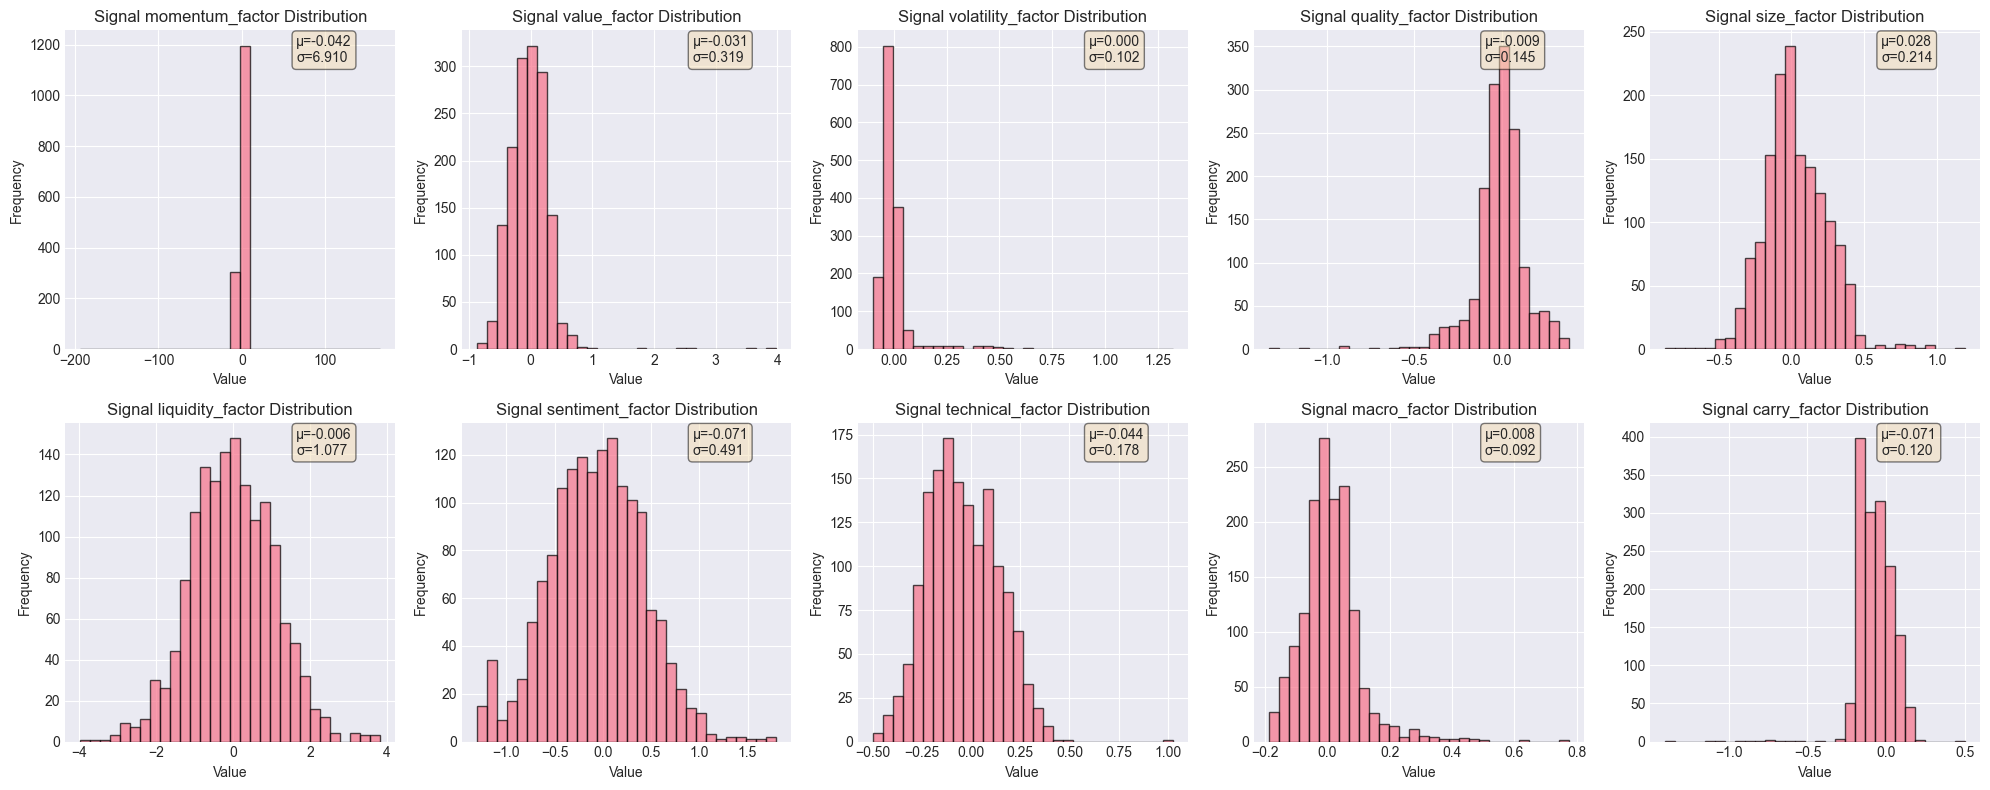

In [63]:
# Visualize signal distributions
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, col in enumerate(signal_cols):
    axes[i].hist(df[col], bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Signal {col} Distribution')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    
    # Add statistics text
    stats_text = f'μ={df[col].mean():.3f}\nσ={df[col].std():.3f}'
    axes[i].text(0.7, 0.9, stats_text, transform=axes[i].transAxes,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## 4. Correlation Analysis

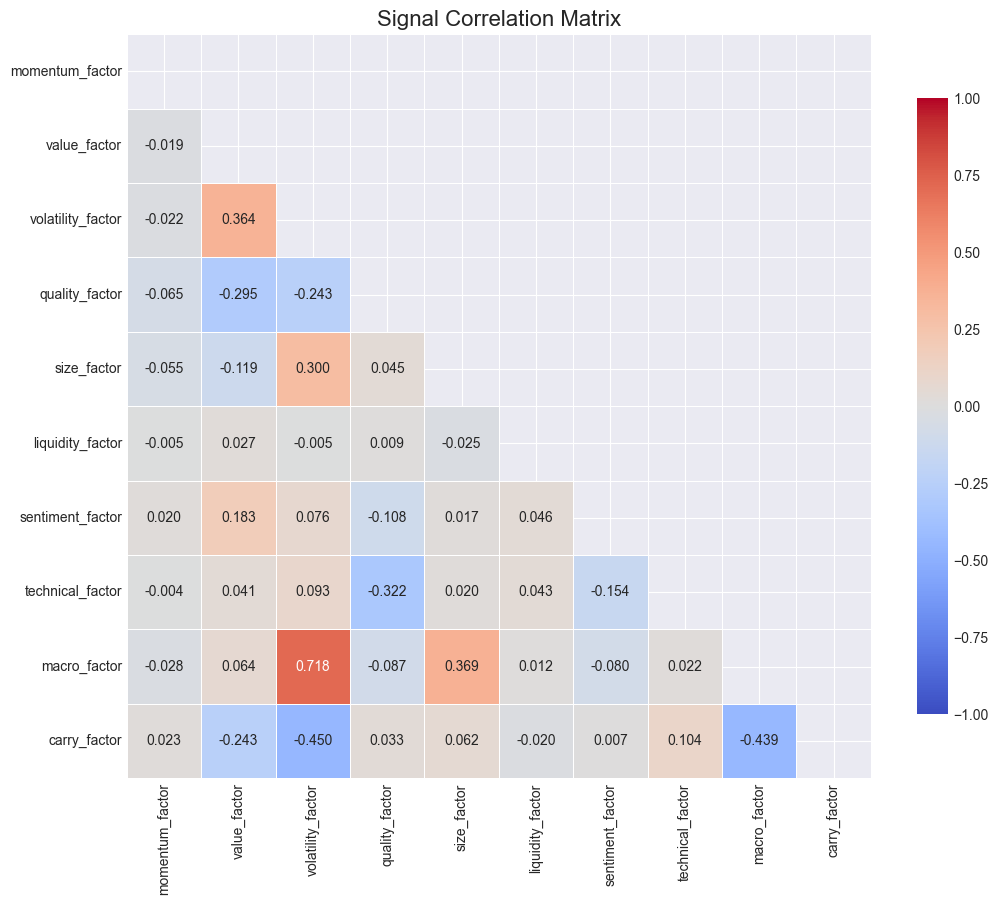

No high correlations found (all |r| ≤ 0.8)

✓ Signals appear to be orthogonal/uncorrelated!


In [64]:
# Calculate correlation matrix
corr_matrix = df[signal_cols].corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', 
            cmap='coolwarm', center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Signal Correlation Matrix', fontsize=16)
plt.show()

# Check for multicollinearity
high_corr_pairs = []
for i in range(len(signal_cols)):
    for j in range(i+1, len(signal_cols)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((signal_cols[i], signal_cols[j], corr_matrix.iloc[i, j]))

if high_corr_pairs:
    print("High correlation pairs (|r| > 0.8):")
    for pair in high_corr_pairs:
        print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")
else:
    print("No high correlations found (all |r| ≤ 0.8)")
    print("\n✓ Signals appear to be orthogonal/uncorrelated!")

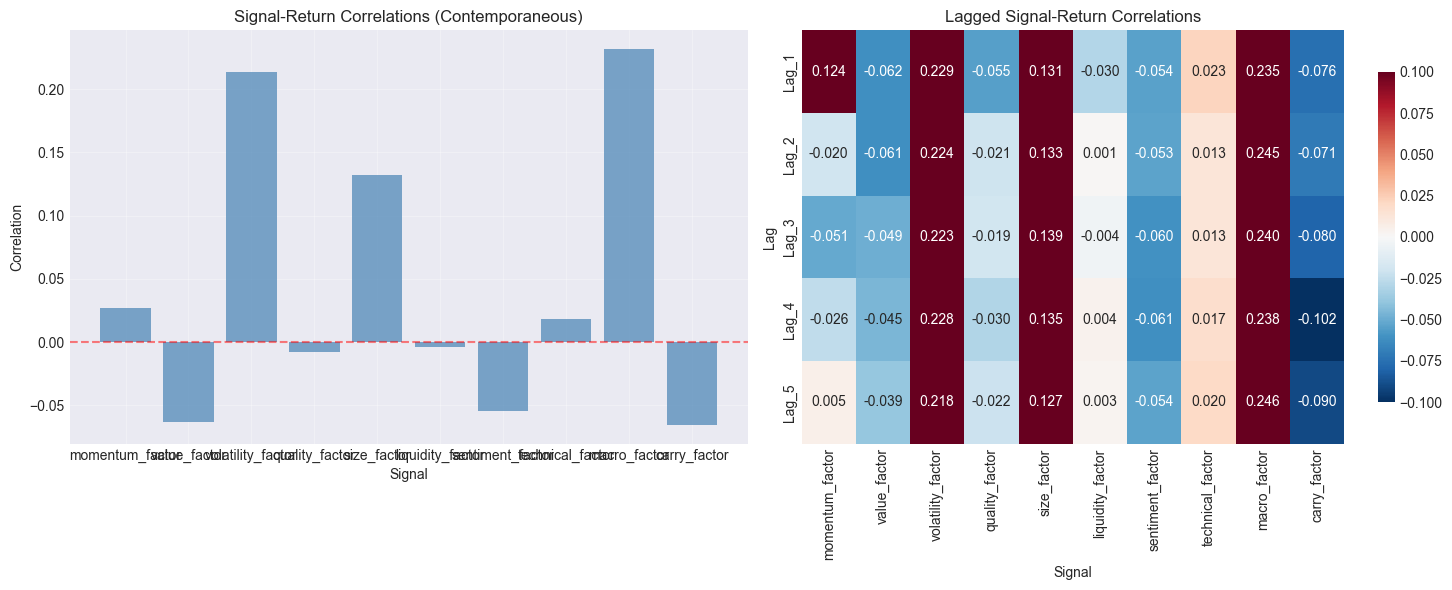

Signal-Return Correlations:
macro_factor         0.231476
volatility_factor    0.213392
size_factor          0.131836
momentum_factor      0.027247
technical_factor     0.018347
liquidity_factor    -0.003885
quality_factor      -0.007507
sentiment_factor    -0.054428
value_factor        -0.062848
carry_factor        -0.065442
dtype: float64


In [65]:
# Signal-Return correlations
signal_return_corr = pd.Series({
    col: df[col].corr(df['Returns']) for col in signal_cols
})

# Lagged correlations
lag_correlations = pd.DataFrame()
for lag in range(1, 6):
    lag_corr = pd.Series({
        col: df[col].shift(lag).corr(df['Returns']) for col in signal_cols
    })
    lag_correlations[f'Lag_{lag}'] = lag_corr

# Visualize signal-return correlations
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Contemporaneous correlations
axes[0].bar(signal_cols, signal_return_corr.values, color='steelblue', alpha=0.7)
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0].set_title('Signal-Return Correlations (Contemporaneous)')
axes[0].set_xlabel('Signal')
axes[0].set_ylabel('Correlation')
axes[0].grid(True, alpha=0.3)

# Lagged correlations heatmap
sns.heatmap(lag_correlations.T, annot=True, fmt='.3f', cmap='RdBu_r', 
            center=0, vmin=-0.1, vmax=0.1, ax=axes[1], cbar_kws={"shrink": 0.8})
axes[1].set_title('Lagged Signal-Return Correlations')
axes[1].set_xlabel('Signal')
axes[1].set_ylabel('Lag')

plt.tight_layout()
plt.show()

print("Signal-Return Correlations:")
print(signal_return_corr.sort_values(ascending=False))

## 5. Time Series Properties

In [66]:
# Test for stationarity
def test_stationarity(series, name):
    """Perform Augmented Dickey-Fuller test for stationarity."""
    result = adfuller(series.dropna())
    print(f'\nADF Test for {name}:')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print(f"✓ {name} is stationary (reject H0)")
    else:
        print(f"✗ {name} is non-stationary (fail to reject H0)")
    return result[1] <= 0.05

# Test returns and signals
stationary_results = {}
stationary_results['Returns'] = test_stationarity(df['Returns'], 'Returns')

for col in signal_cols[:3]:  # Test first 3 signals as example
    stationary_results[col] = test_stationarity(df[col], col)


ADF Test for Returns:
ADF Statistic: -6.152040
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
✓ Returns is stationary (reject H0)

ADF Test for momentum_factor:
ADF Statistic: -38.047304
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
✓ momentum_factor is stationary (reject H0)

ADF Test for value_factor:
ADF Statistic: -5.165024
p-value: 0.000010
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
✓ value_factor is stationary (reject H0)

ADF Test for volatility_factor:
ADF Statistic: -11.922291
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
✓ volatility_factor is stationary (reject H0)


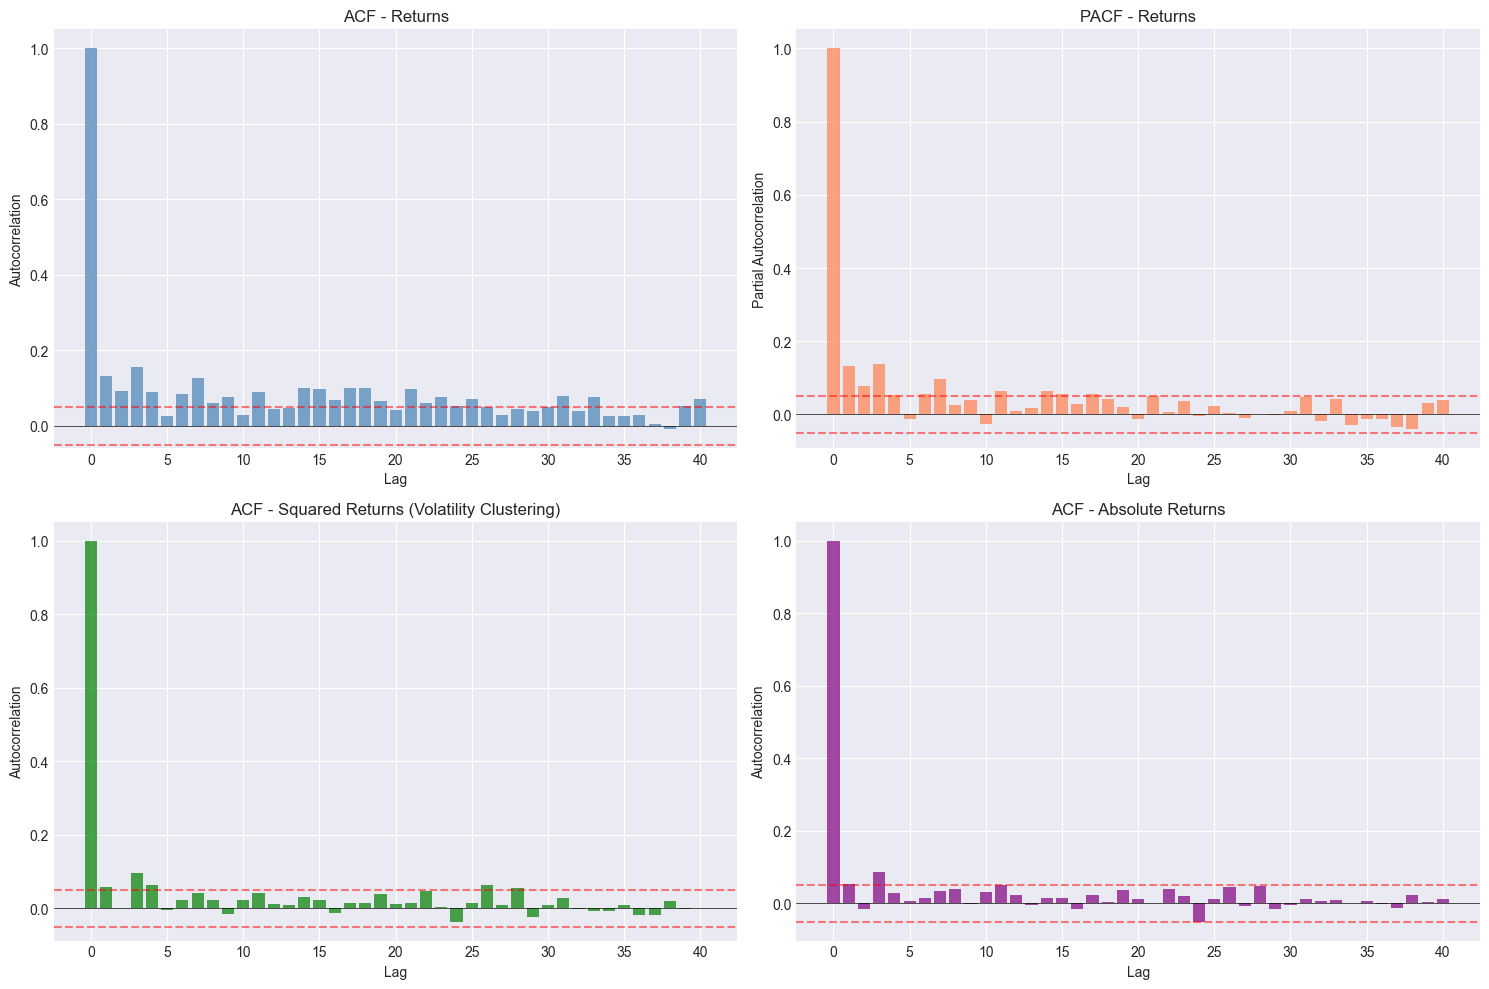

In [67]:
# Autocorrelation analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# ACF for returns
acf_returns = acf(df['Returns'].dropna(), nlags=40)
axes[0, 0].bar(range(len(acf_returns)), acf_returns, color='steelblue', alpha=0.7)
axes[0, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0, 0].axhline(y=1.96/np.sqrt(len(df)), color='red', linestyle='--', alpha=0.5)
axes[0, 0].axhline(y=-1.96/np.sqrt(len(df)), color='red', linestyle='--', alpha=0.5)
axes[0, 0].set_title('ACF - Returns')
axes[0, 0].set_xlabel('Lag')
axes[0, 0].set_ylabel('Autocorrelation')

# PACF for returns
pacf_returns = pacf(df['Returns'].dropna(), nlags=40)
axes[0, 1].bar(range(len(pacf_returns)), pacf_returns, color='coral', alpha=0.7)
axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0, 1].axhline(y=1.96/np.sqrt(len(df)), color='red', linestyle='--', alpha=0.5)
axes[0, 1].axhline(y=-1.96/np.sqrt(len(df)), color='red', linestyle='--', alpha=0.5)
axes[0, 1].set_title('PACF - Returns')
axes[0, 1].set_xlabel('Lag')
axes[0, 1].set_ylabel('Partial Autocorrelation')

# ACF for squared returns (volatility clustering)
squared_returns = df['Returns'] ** 2
acf_squared = acf(squared_returns.dropna(), nlags=40)
axes[1, 0].bar(range(len(acf_squared)), acf_squared, color='green', alpha=0.7)
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 0].axhline(y=1.96/np.sqrt(len(df)), color='red', linestyle='--', alpha=0.5)
axes[1, 0].axhline(y=-1.96/np.sqrt(len(df)), color='red', linestyle='--', alpha=0.5)
axes[1, 0].set_title('ACF - Squared Returns (Volatility Clustering)')
axes[1, 0].set_xlabel('Lag')
axes[1, 0].set_ylabel('Autocorrelation')

# ACF for absolute returns
abs_returns = np.abs(df['Returns'])
acf_abs = acf(abs_returns.dropna(), nlags=40)
axes[1, 1].bar(range(len(acf_abs)), acf_abs, color='purple', alpha=0.7)
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 1].axhline(y=1.96/np.sqrt(len(df)), color='red', linestyle='--', alpha=0.5)
axes[1, 1].axhline(y=-1.96/np.sqrt(len(df)), color='red', linestyle='--', alpha=0.5)
axes[1, 1].set_title('ACF - Absolute Returns')
axes[1, 1].set_xlabel('Lag')
axes[1, 1].set_ylabel('Autocorrelation')

plt.tight_layout()
plt.show()

## 6. Key Findings and Hypotheses

In [68]:
# Summary of key findings
print("\n" + "="*80)
print("KEY FINDINGS FROM EXPLORATORY DATA ANALYSIS")
print("="*80)

findings = [
    ("Data Structure", [
        f"Total observations: {len(df)}",
        f"Features: 10 signals (F1-F10)",
        f"Target: Asset returns",
        f"Transaction cost: {transaction_cost:.1%}"
    ]),
    
    ("Return Characteristics", [
        f"Annualized return: {return_stats['Annualized Return']:.2%}",
        f"Annualized volatility: {return_stats['Annualized Volatility']:.2%}",
        f"Sharpe ratio: {return_stats['Sharpe Ratio']:.3f}",
        f"Skewness: {return_stats['Skewness']:.3f} (slightly negative)",
        f"Kurtosis: {return_stats['Kurtosis']:.3f} ({'leptokurtic' if return_stats['Kurtosis'] > 3 else 'platykurtic'})",
        f"Normality: {'Rejected' if jb_pvalue < 0.05 else 'Not rejected'} (p={jb_pvalue:.4f})"
    ]),
]

# Print formatted findings
for section, bullets in findings:
    print("\n" + section)
    print("-" * len(section))
    for line in bullets:
        print(f"• {line}")

# Add a short signal-return correlation summary
if 'signal_return_corr' in globals():
    print("\nSignal-Return Correlations (summary)")
    print("-" * 36)
    sorted_corr = signal_return_corr.sort_values(ascending=False)
    print("Top 3 positive correlations:")
    for name, val in sorted_corr.head(3).items():
        print(f"• {name}: {val:.3f}")
    print("Top 3 negative correlations:")
    for name, val in sorted_corr.tail(3).items():
        print(f"• {name}: {val:.3f}")
    


KEY FINDINGS FROM EXPLORATORY DATA ANALYSIS

Data Structure
--------------
• Total observations: 1500
• Features: 10 signals (F1-F10)
• Target: Asset returns
• Transaction cost: 0.5%

Return Characteristics
----------------------
• Annualized return: -4.04%
• Annualized volatility: 9.40%
• Sharpe ratio: -0.429
• Skewness: 0.028 (slightly negative)
• Kurtosis: 3.097 (leptokurtic)
• Normality: Not rejected (p=0.6728)

Signal-Return Correlations (summary)
------------------------------------
Top 3 positive correlations:
• macro_factor: 0.231
• volatility_factor: 0.213
• size_factor: 0.132
Top 3 negative correlations:
• sentiment_factor: -0.054
• value_factor: -0.063
• carry_factor: -0.065


In [69]:
# Save processed data for next notebooks
df.to_csv('../data/processed/clean_data.csv', index=False)
print("Data saved to 'data/processed/clean_data.csv'")

# Save key statistics
stats_summary = {
    'transaction_cost': transaction_cost,
    'return_stats': return_stats,
    'signal_stats': signal_stats.to_dict(),
    'signal_return_correlations': signal_return_corr.to_dict()
}

import json
with open('../data/processed/eda_summary1.json', 'w') as f:
    json.dump(stats_summary, f, indent=2, default=str)
print("Statistics saved to 'data/processed/eda_summary1.json'")

Data saved to 'data/processed/clean_data.csv'
Statistics saved to 'data/processed/eda_summary1.json'
